<a href="https://colab.research.google.com/github/0Kyumy0/Machine_Learning_CodingDojo/blob/Supervised_models/exerciseBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn import set_config
set_config(display='diagram')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [2]:
filename = '/content/drive/MyDrive/DataScience/Semana8/census_income.xlsx'
df = pd.read_excel(filename)
df.head()

,Unnamed: 0,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32561 non-null  int64 
 1   age             32561 non-null  int64 
 2   workclass       32561 non-null  object
 3   education       32561 non-null  object
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  income-class    32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


# Data cleaning

In [4]:
df.isna().sum()

Unnamed: 0        0
age               0
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income-class      0
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df = df.drop(columns = 'Unnamed: 0')

In [7]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
df['race'].value_counts() # everything ok

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64

In [9]:
df['sex'].value_counts() # everything ok

Male      21790
Female    10771
Name: sex, dtype: int64

In [10]:
# the age values are reasonable
print(df['age'].min())
print(df['age'].max())

17
90


In [11]:
df['workclass'].value_counts()  # theres a weird symbol on the values.

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [12]:
df.loc[(df['native-country'] == '?'), :] # all of the rows with the '?' symbol are of the white race

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
14,40,Private,Assoc-voc,Married-civ-spouse,Craft-repair,Husband,Asian-Pac-Islander,Male,0,0,40,?,>50K
38,31,Private,Some-college,Married-civ-spouse,Sales,Husband,White,Male,0,0,38,?,>50K
51,18,Private,HS-grad,Never-married,Other-service,Own-child,White,Female,0,0,30,?,<=50K
61,32,?,7th-8th,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
93,30,Private,HS-grad,Married-civ-spouse,Sales,Wife,Asian-Pac-Islander,Female,0,1573,35,?,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32449,44,Self-emp-inc,Masters,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,?,>50K
32469,58,Self-emp-inc,Doctorate,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,99,?,<=50K
32492,42,Self-emp-not-inc,HS-grad,Divorced,Sales,Own-child,White,Male,0,0,50,?,<=50K
32510,39,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,?,>50K


In [13]:
# I´m going to change the simbol with the value 'United-States' 
# since is the the most common value with the value 'white' on the race column, 
# so theres no that much of a loss with the data
df_white = df.loc[df['race']=='White', : ]
df_white['native-country'].value_counts()

United-States                 25621
Mexico                          590
?                               386
Germany                         124
Canada                          119
El-Salvador                     101
Cuba                             90
Puerto-Rico                      82
England                          81
Italy                            73
Guatemala                        60
Poland                           59
Columbia                         51
Dominican-Republic               39
Portugal                         36
Iran                             35
Peru                             30
France                           28
Greece                           28
Nicaragua                        28
Ireland                          23
Ecuador                          19
Japan                            19
Yugoslavia                       16
Hungary                          13
Honduras                         12
Scotland                         12
India                       

In [14]:
df['native-country'] = df['native-country'].replace('?', 'United-States')

In [15]:
# since the data with missing values is about a 5.6% of the total data, im going to delete the corresponding rows.
df_delete = df.loc[(df['workclass'] == '?') & (df['occupation'] == '?'), :]
df = df.drop(df_delete.index)

In [16]:
# Based on the information we obtained previously, we can see that there are 7 rows that mention they have never worked. 
# Therefore, in the occupation column, we can add a new data point related to their status in 'workclass'.
df.loc[df['occupation'] == '?', :]

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
5361,18,Never-worked,10th,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
10845,23,Never-worked,7th-8th,Divorced,?,Not-in-family,White,Male,0,0,35,United-States,<=50K
14772,17,Never-worked,10th,Never-married,?,Own-child,White,Male,0,0,30,United-States,<=50K
20337,18,Never-worked,11th,Never-married,?,Own-child,White,Female,0,0,10,United-States,<=50K
23232,20,Never-worked,Some-college,Never-married,?,Own-child,Black,Male,0,0,40,United-States,<=50K
32304,30,Never-worked,HS-grad,Married-civ-spouse,?,Wife,Black,Female,0,0,40,United-States,<=50K
32314,18,Never-worked,Some-college,Never-married,?,Own-child,White,Male,0,0,4,United-States,<=50K


In [17]:
df['occupation'] = df['occupation'].replace('?', 'None')

In [18]:
df['occupation'].value_counts() # the change was done correctly

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
None                    7
Name: occupation, dtype: int64

In [19]:
range = [(17, 25), (26, 40), (41, 60), (61, 80), (81, 90)]
age_oe = [0, 1, 2, 3, 4]

# I replace the ages by a age range so it's easier to classify
for range, age_oe in zip(range, age_oe):
    df['age'] = np.where((df['age'] >= range[0]) & (df['age'] <= range[1]), age_oe, df['age'])

In [20]:
df['age'].value_counts()

1    12349
2    10790
0     5747
3     1762
4       77
Name: age, dtype: int64

In [21]:
df['income-class'].value_counts()

<=50K    23075
>50K      7650
Name: income-class, dtype: int64

In [22]:
# since these are the only two values for the column 'income-class' based on the objective of the project,
# I replace them before the pre-processing.
df['income-class'] = df['income-class'].replace({'<=50K': 0, '>50K': 1})
df['income-class'].value_counts()

0    23075
1     7650
Name: income-class, dtype: int64

In [23]:
df['income-class'] = df['income-class'].astype(int)

In [24]:
# I changed the value type to float as we are dealing with money, and this will facilitate the necessary processing later on.
df['capital-gain'] = df['capital-gain'].astype(float)
df['capital-loss'] = df['capital-loss'].astype(float)

# Pre-processing

In [25]:
df.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,1,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40,United-States,0
1,2,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13,United-States,0
2,1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40,United-States,0
3,2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40,United-States,0
4,1,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40,Cuba,0


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30725 entries, 0 to 32560
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30725 non-null  int64  
 1   workclass       30725 non-null  object 
 2   education       30725 non-null  object 
 3   marital-status  30725 non-null  object 
 4   occupation      30725 non-null  object 
 5   relationship    30725 non-null  object 
 6   race            30725 non-null  object 
 7   sex             30725 non-null  object 
 8   capital-gain    30725 non-null  float64
 9   capital-loss    30725 non-null  float64
 10  hours-per-week  30725 non-null  int64  
 11  native-country  30725 non-null  object 
 12  income-class    30725 non-null  int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 3.3+ MB


In [27]:
df['income-class'].value_counts(normalize=True) # the data is unbalanced

0    0.751017
1    0.248983
Name: income-class, dtype: float64

In [215]:
y = df['income-class']
X = df.drop(columns='income-class')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.4, stratify=y)

In [216]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='float')

In [217]:
# I separate the columns that are already in order to later 
# concatenate them to the final data frame for both train and test datasets.
columna_1_train = X_train['age']
columna_2_train = X_train['hours-per-week']

columna_1_test = X_test['age']
columna_2_test = X_test['hours-per-week']

In [218]:
columna_1_train = columna_1_train.reset_index(drop=True)
columna_2_train = columna_2_train.reset_index(drop=True)

columna_1_test = columna_1_test.reset_index(drop=True)
columna_2_test = columna_2_test.reset_index(drop=True)

In [219]:
scaler = StandardScaler()
ohe = OneHotEncoder()

In [220]:
cat_pipeline = make_pipeline(ohe)
cat_pipeline

Pipeline(steps=[('onehotencoder', OneHotEncoder())])

In [221]:
num_pipeline = make_pipeline(scaler)
num_pipeline

Pipeline(steps=[('standardscaler', StandardScaler())])

In [222]:
cat_tuple = (cat_pipeline, cat_selector)
num_tuple = (num_pipeline, num_selector)

In [223]:
preprocessor = make_column_transformer(num_tuple, cat_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f897b0c8460>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f897b0c9f30>)])

In [224]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f897b0c8460>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f897b0c9f30>)])

In [225]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [226]:
X_train_processed = X_train_processed.toarray()
X_test_processed = X_test_processed.toarray()

In [228]:
df_train_processed = pd.DataFrame(X_train_processed)
# df_train_processed = pd.concat([df_train_processed, 
#                                 columna_1_train.reset_index(drop=True), 
#                                 columna_2_train.reset_index(drop=True)], 
#                                 axis=1)
df_train_processed['age'] = columna_1_train
df_train_processed['hours-per-week'] = columna_2_train
df_train_processed.columns = df_train_processed.columns.astype(str)
df_train_processed

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,age,hours-per-week
0,0.832094,-0.218136,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,35
1,-0.146340,-0.218136,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,20
2,-0.146340,-0.218136,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,38
3,-0.146340,-0.218136,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,48
4,-0.146340,-0.218136,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18430,-0.146340,4.740343,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,60
18431,-0.146340,-0.218136,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,45
18432,-0.146340,-0.218136,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,20
18433,-0.146340,-0.218136,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,38


In [229]:
df_test_processed = pd.DataFrame(X_test_processed)

df_test_processed['age'] = columna_1_test
df_test_processed['hours-per-week'] = columna_2_test
df_test_processed.columns = df_test_processed.columns.astype(str)

# Boosting models

## Potenciación del gradiente

In [230]:
gbc = GradientBoostingClassifier()
gbc.fit(df_train_processed, y_train)

gbc_pred = gbc.predict(df_test_processed)

print(gbc.score(df_train_processed, y_train)*100)
print(gbc.score(df_test_processed, y_test)*100)

86.41171684296177
85.99674532139952


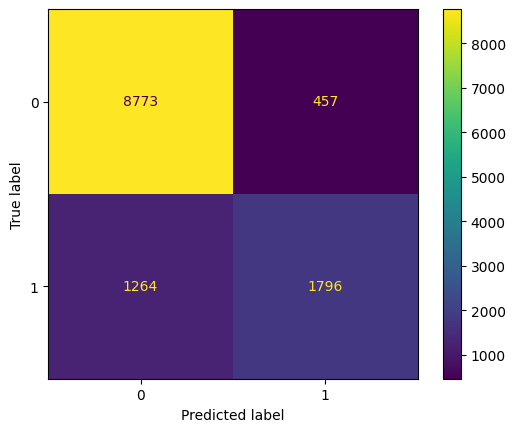

In [231]:
cm = confusion_matrix(y_test, gbc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot();

In [232]:
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      9230
           1       0.80      0.59      0.68      3060

    accuracy                           0.86     12290
   macro avg       0.84      0.77      0.79     12290
weighted avg       0.85      0.86      0.85     12290



## LightGBM

In [233]:
lgbm = LGBMClassifier()
lgbm.fit(df_train_processed, y_train)

print(lgbm.score(df_train_processed, y_train)*100)
print(lgbm.score(df_test_processed, y_test)*100)

88.22348793056686
86.79414157851912


In [234]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [237]:
param_grid = [
  {'n_estimators': np.arange(100, 110, 1), 
   'max_depth': np.arange(1, 10, 1)}
]

lgbm = LGBMClassifier()

grid_search = GridSearchCV(lgbm, 
                           param_grid, 
                           cv=5,
                           scoring='f1_macro')

grid_search.fit(df_train_processed, y_train)

grid_search.best_params_

{'max_depth': 9, 'n_estimators': 108}

7 104

In [239]:
lgbm = LGBMClassifier(max_depth=9, n_estimators=108)
lgbm.fit(df_train_processed, y_train)

lgbm_preds = lgbm.predict(df_test_processed)

print(lgbm.score(df_train_processed, y_train)*100)
print(lgbm.score(df_test_processed, y_test)*100)

88.22348793056686
86.79414157851912


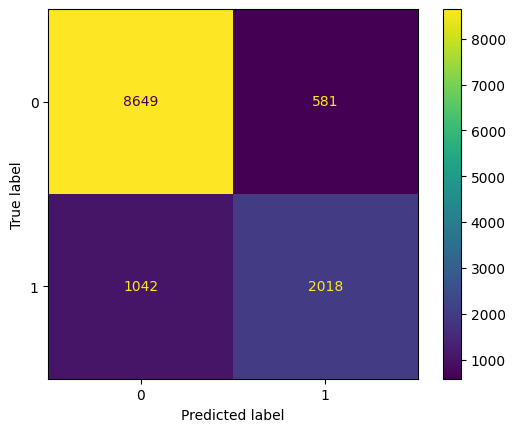

In [240]:
cm = confusion_matrix(y_test, lgbm_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot();

In [241]:
print(classification_report(y_test, lgbm_preds))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      9230
           1       0.78      0.66      0.71      3060

    accuracy                           0.87     12290
   macro avg       0.83      0.80      0.81     12290
weighted avg       0.86      0.87      0.86     12290



## XGBoost

In [242]:
xgb = XGBClassifier()
xgb.fit(df_train_processed, y_train)

xgb_preds = xgb.predict(df_test_processed)

print(xgb.score(df_train_processed, y_train)*100)
print(xgb.score(df_test_processed, y_test)*100)

88.70084079197179
86.72904800650936


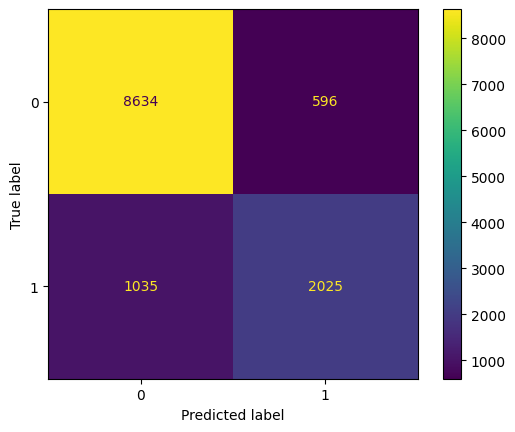

In [243]:
cm = confusion_matrix(y_test, xgb_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot();

In [244]:
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      9230
           1       0.77      0.66      0.71      3060

    accuracy                           0.87     12290
   macro avg       0.83      0.80      0.81     12290
weighted avg       0.86      0.87      0.86     12290



### NOTES:
In my opinion, the best models for this task were both LightGBM and XGBoost since they had quite similar results in terms of their confusion matrix, showing an identical f1-score. This information shows that reinforcement is needed for positive values as there is a weakness in their ability to identify such values.

Now, looking at the accuracy results, a more preferable value (by decimals) was obtained with the LightGBM model on the test data, but either of the two models is good based on the results obtained.